In [1]:
from matplotlib import pyplot as plt
from typing import Tuple, Any
import cv2
import random
import numpy as np
import pandas as pd
import os
import torch.nn as nn
from PIL import Image
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

In [3]:
csv = "D:/python/annotation_dataset.csv"
data = pd.read_csv(csv,  usecols=[0, 2])
(data)

,absolute_path,class
0,D:\python\dataset\leopard\0000.jpg,leopard
1,D:\python\dataset\leopard\0001.jpg,leopard
2,D:\python\dataset\leopard\0002.jpg,leopard
3,D:\python\dataset\leopard\0003.jpg,leopard
4,D:\python\dataset\leopard\0004.jpg,leopard
...,...,...
2035,D:\python\dataset\tiger\1015.jpg,tiger
2036,D:\python\dataset\tiger\1016.jpg,tiger
2037,D:\python\dataset\tiger\1017.jpg,tiger
2038,D:\python\dataset\tiger\1018.jpg,tiger


In [4]:
names = set(data["class"].to_list())

In [5]:
splited_by_class, train_list, test_list, val_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
i = 0
for name in names:
    splited_by_class = data.loc[data['class'] == name]
    train_list = pd.concat([train_list, splited_by_class[0 : int(len(splited_by_class) * 0.8)]], )
    test_list = pd.concat([test_list, splited_by_class[int(len(splited_by_class) * 0.8) : int(len(splited_by_class) * 0.9)]], ignore_index = True)
    val_list = pd.concat([val_list, splited_by_class[int(len(splited_by_class) * 0.9) : int(len(splited_by_class))]], ignore_index = True)
    i+=1
print(len(train_list), len(test_list), len(val_list))

1632 204 204


Проверка на сбалансированность

In [6]:
train_stats = train_list['class'].value_counts()
test_stats = train_list['class'].value_counts()
val_stats = train_list['class'].value_counts()
if not train_stats.min() / train_stats.max() >= 0.98:
    print("not ok")
elif not test_stats.min() / test_stats.max() >= 0.98:
    print("not ok")
elif not val_stats.min() / val_stats.max() >= 0.98:
    print("not ok")
else:
    print("ok")

ok


Класс для хранения картинок

In [7]:
class CustomDataset(torch.utils.data.Dataset):
  """Class to store images"""
  def __init__(self, images, transform:Any=None) -> None:
        self.dataset = images
        self.transform = transform

  def __len__(self) -> int:
    return len(self.dataset)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    path_to_image = self.dataset.iloc[index, 0]
    image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
    image = self.transform(image)
    label = self.dataset.iloc[index, 1]

    if label == "tiger":
       label = 0
    elif label == "leopard":
       label = 1

    return image, label

Предобработка

In [10]:
print(train_list.__len__())
print(val_list.__len__())
print(test_list.__len__())

1632
204
204


In [8]:
custom_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        ]
)
train_data = CustomDataset(train_list, transform=custom_transforms)
test_data = CustomDataset(test_list, transform=custom_transforms)
val_data = CustomDataset(val_list, transform=custom_transforms)
test_data.__len__()

204

In [13]:
test_data[0][0].shape

C:\Users\zabir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224])

Модель свёрточной нейросети

In [9]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(576,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return output

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = CNN()
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Графики

In [42]:
def chart(epochs, train_acc, train_loss, valid_acc, valid_loss) -> None:
    """Creates graphs based on the learning results"""
    fig = plt.figure(figsize=(15, 5))

    fig.add_subplot(1, 2, 1)
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.plot(range(epochs) ,train_loss , color='red', linestyle='-', linewidth=1, label='Train loss')
    plt.plot(range(epochs) ,valid_loss , color='blue', linestyle='-', linewidth=1, label='Validation loss')
    plt.legend()

    fig.add_subplot(1, 2, 2)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(range(epochs), train_acc, color='red', linestyle='-', linewidth=1, label='Train accuracy') 
    plt.plot(range(epochs), valid_acc, color='blue', linestyle='-', linewidth=1, label='Validation accuracy') 
    plt.legend()

    plt.show()

In [14]:
def train_loop(epochs, batch_size, lear) -> Tuple[list, CNN]:
    optimizer = optim.Adam(params=model.parameters(), lr=lear)
    criterion = nn.CrossEntropyLoss()
    train_accuracy_values = []
    train_loss_values = []

    val_accuracy_values = []
    val_loss_values = []
    valid_loader = torch.utils.data.DataLoader(
        dataset=val_data, batch_size=batch_size, shuffle=False
    )
    train_loader = torch.utils.data.DataLoader(
        dataset=train_data, batch_size=batch_size, shuffle=True
    )
    

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0


        model.train()
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()

            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)
        print(
           f"Epoch : {epoch + 1}, train accuracy : {epoch_accuracy}, train loss : {epoch_loss}"
        )
        train_accuracy_values.append(epoch_accuracy)
        train_loss_values.append(epoch_loss.detach().numpy())
        model.eval()
        epoch_val_loss = 0
        epoch_val_accuracy = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()

            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += loss / len(valid_loader)

        val_accuracy_values.append(epoch_val_accuracy)
        val_loss_values.append(epoch_val_loss.detach().numpy())

        print(
                f"Epoch : {epoch + 1}, val_accuracy : {epoch_val_accuracy}, val_loss : {epoch_val_loss}"
            )
    chart(epochs, train_accuracy_values, train_loss_values, val_accuracy_values, val_loss_values)

Обучение.

Epoch : 1, train accuracy : 0.9616910815238953, train loss : 0.09301435202360153
Epoch : 1, val_accuracy : 0.9733333587646484, val_loss : 0.1008635014295578
Epoch : 2, train accuracy : 0.9692646265029907, train loss : 0.07056427001953125
Epoch : 2, val_accuracy : 0.7900000214576721, val_loss : 0.263409286737442
Epoch : 3, train accuracy : 0.9735292792320251, train loss : 0.06632771342992783
Epoch : 3, val_accuracy : 0.9733333587646484, val_loss : 0.06389898806810379
Epoch : 4, train accuracy : 0.9717645645141602, train loss : 0.06653333455324173
Epoch : 4, val_accuracy : 0.6399999856948853, val_loss : 0.8812427520751953
Epoch : 5, train accuracy : 0.965735137462616, train loss : 0.09056898951530457
Epoch : 5, val_accuracy : 0.9733333587646484, val_loss : 0.07829217612743378
Epoch : 6, train accuracy : 0.9645587801933289, train loss : 0.07989059388637543
Epoch : 6, val_accuracy : 0.996666669845581, val_loss : 0.024953341111540794
Epoch : 7, train accuracy : 0.9658821821212769, train los

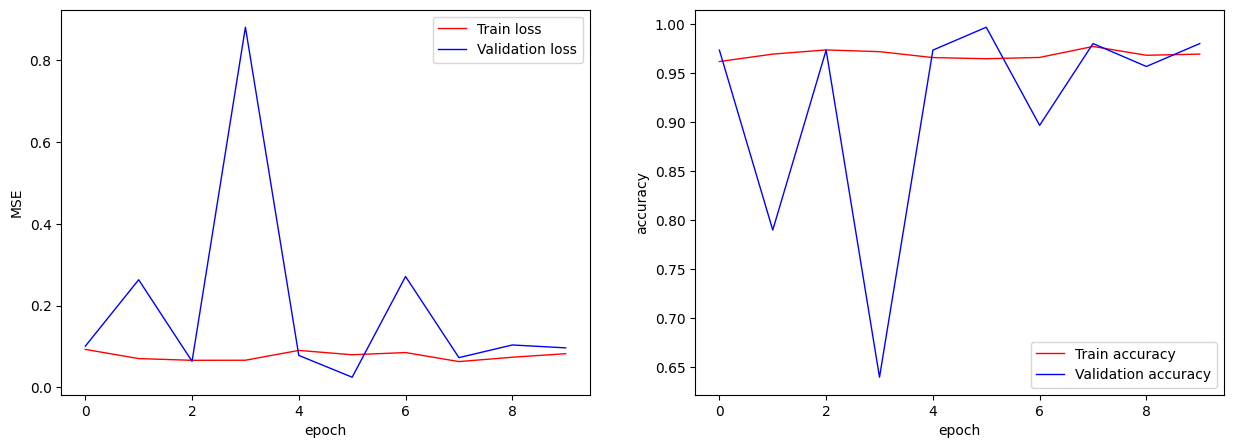

In [43]:
train_loop(10, 100, 0.001)

Epoch : 1, train accuracy : 0.9744444489479065, train loss : 0.06714007258415222
Epoch : 1, val_accuracy : 0.9850000143051147, val_loss : 0.09567561000585556
Epoch : 2, train accuracy : 0.9788889288902283, train loss : 0.05544973909854889
Epoch : 2, val_accuracy : 0.9650000333786011, val_loss : 0.11614711582660675
Epoch : 3, train accuracy : 0.9776389598846436, train loss : 0.053858526051044464
Epoch : 3, val_accuracy : 0.9674999713897705, val_loss : 0.13893723487854004
Epoch : 4, train accuracy : 0.9726389646530151, train loss : 0.06258399784564972
Epoch : 4, val_accuracy : 0.9750000238418579, val_loss : 0.04950116574764252
Epoch : 5, train accuracy : 0.972083330154419, train loss : 0.05963488668203354
Epoch : 5, val_accuracy : 0.8324999809265137, val_loss : 0.5714179873466492
Epoch : 6, train accuracy : 0.974861204624176, train loss : 0.06711475551128387
Epoch : 6, val_accuracy : 0.9824999570846558, val_loss : 0.06423864513635635
Epoch : 7, train accuracy : 0.9769445061683655, train 

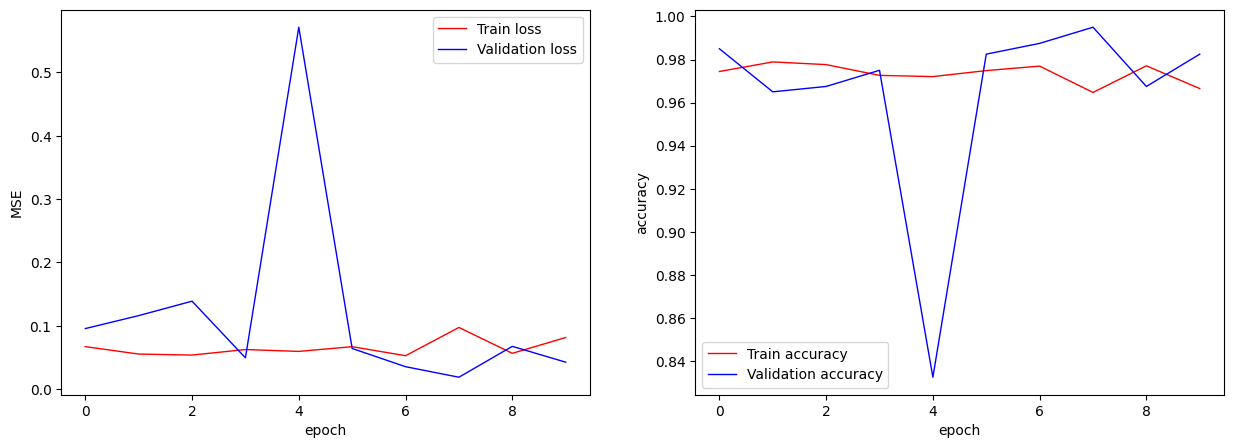

In [44]:
train_loop(10, 200, 0.001)

Epoch : 1, train accuracy : 0.9615000486373901, train loss : 0.09775308519601822
Epoch : 1, val_accuracy : 0.9166666865348816, val_loss : 0.22259403765201569
Epoch : 2, train accuracy : 0.9810000061988831, train loss : 0.049209561198949814
Epoch : 2, val_accuracy : 0.9509803652763367, val_loss : 0.09362678229808807
Epoch : 3, train accuracy : 0.9779999852180481, train loss : 0.05170716345310211
Epoch : 3, val_accuracy : 0.936274528503418, val_loss : 0.15453141927719116
Epoch : 4, train accuracy : 0.9730000495910645, train loss : 0.055923379957675934
Epoch : 4, val_accuracy : 0.9607843160629272, val_loss : 0.07059269398450851
Epoch : 5, train accuracy : 0.9607499837875366, train loss : 0.08160115778446198
Epoch : 5, val_accuracy : 0.9460784196853638, val_loss : 0.09924305975437164
Epoch : 6, train accuracy : 0.9785000085830688, train loss : 0.05334697663784027
Epoch : 6, val_accuracy : 0.843137264251709, val_loss : 0.38025620579719543
Epoch : 7, train accuracy : 0.969249963760376, train

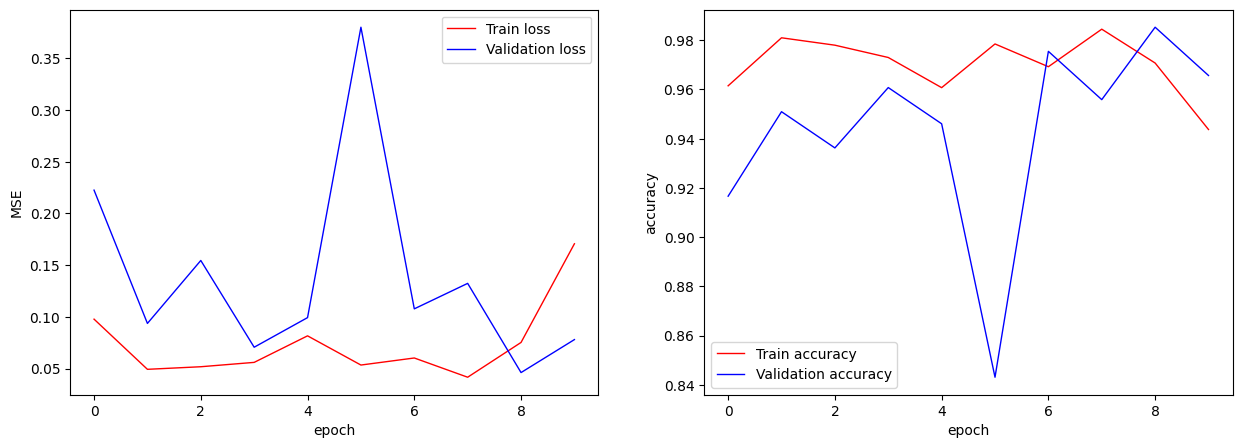

In [45]:
train_loop(10, 400, 0.001)

Epoch : 1, train accuracy : 0.9705145955085754, train loss : 0.0765247493982315
Epoch : 1, val_accuracy : 0.8566666841506958, val_loss : 0.5052024126052856
Epoch : 2, train accuracy : 0.9676469564437866, train loss : 0.08369019627571106
Epoch : 2, val_accuracy : 0.8933333158493042, val_loss : 0.14511525630950928
Epoch : 3, train accuracy : 0.9711763858795166, train loss : 0.08087632805109024
Epoch : 3, val_accuracy : 0.9300000667572021, val_loss : 0.17647215723991394
Epoch : 4, train accuracy : 0.9645587205886841, train loss : 0.08289056271314621
Epoch : 4, val_accuracy : 0.9300000667572021, val_loss : 0.22954797744750977
Epoch : 5, train accuracy : 0.967499852180481, train loss : 0.08259662985801697
Epoch : 5, val_accuracy : 0.8633333444595337, val_loss : 0.3376898765563965
Epoch : 6, train accuracy : 0.9747057557106018, train loss : 0.0684242695569992
Epoch : 6, val_accuracy : 0.9700000286102295, val_loss : 0.08608690649271011
Epoch : 7, train accuracy : 0.9716911315917969, train los

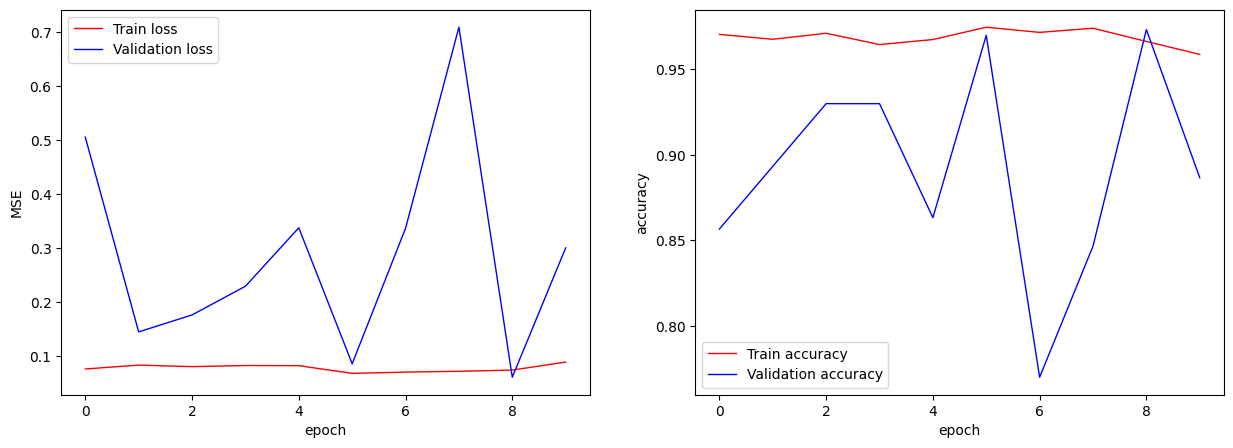

In [46]:
train_loop(10, 100, 0.002)

Epoch : 1, train accuracy : 0.9516175985336304, train loss : 0.12285979837179184
Epoch : 1, val_accuracy : 0.8566666841506958, val_loss : 0.28646087646484375
Epoch : 2, train accuracy : 0.957573413848877, train loss : 0.10561259090900421
Epoch : 2, val_accuracy : 0.9733333587646484, val_loss : 0.06849303841590881
Epoch : 3, train accuracy : 0.9652204513549805, train loss : 0.08357303589582443
Epoch : 3, val_accuracy : 0.8899999856948853, val_loss : 0.13452941179275513
Epoch : 4, train accuracy : 0.9705145955085754, train loss : 0.06693843752145767
Epoch : 4, val_accuracy : 0.9133334159851074, val_loss : 0.3077368140220642
Epoch : 5, train accuracy : 0.9538235068321228, train loss : 0.11645926535129547
Epoch : 5, val_accuracy : 0.8566666841506958, val_loss : 0.27210766077041626
Epoch : 6, train accuracy : 0.9469852447509766, train loss : 0.13182145357131958
Epoch : 6, val_accuracy : 0.9533333778381348, val_loss : 0.1255306601524353
Epoch : 7, train accuracy : 0.9450734853744507, train l

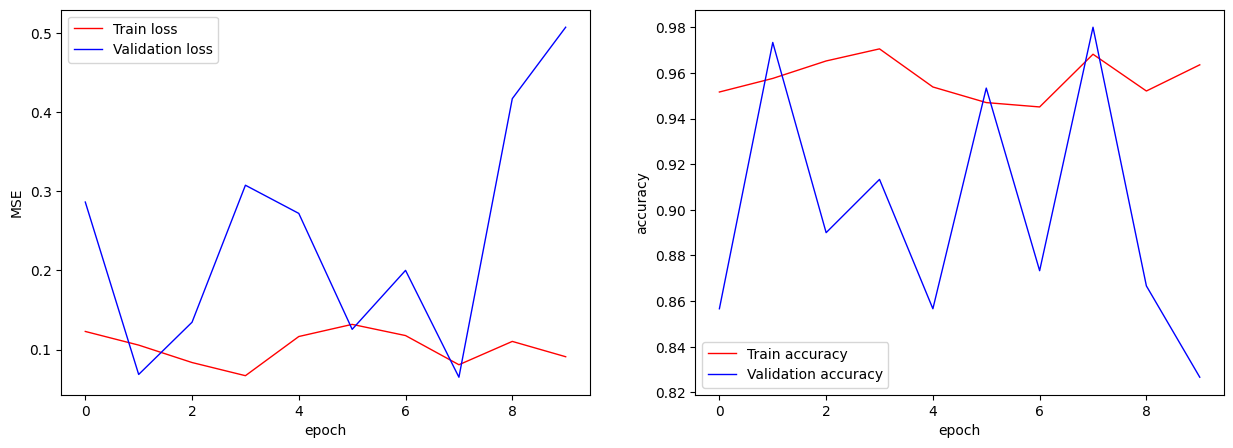

In [47]:
train_loop(10, 100, 0.003)

Epoch : 1, train accuracy : 0.9630556106567383, train loss : 0.09718401730060577
Epoch : 1, val_accuracy : 0.9750000238418579, val_loss : 0.0852794200181961
Epoch : 2, train accuracy : 0.9601389169692993, train loss : 0.10107401758432388
Epoch : 2, val_accuracy : 0.48750001192092896, val_loss : 1.563804030418396
Epoch : 3, train accuracy : 0.9648610949516296, train loss : 0.07873150706291199
Epoch : 3, val_accuracy : 0.9700000286102295, val_loss : 0.09462609142065048
Epoch : 4, train accuracy : 0.9475000500679016, train loss : 0.09130536019802094
Epoch : 4, val_accuracy : 0.6675000190734863, val_loss : 0.7860507965087891
Epoch : 5, train accuracy : 0.9625000357627869, train loss : 0.07944530248641968
Epoch : 5, val_accuracy : 0.9300000071525574, val_loss : 0.18114730715751648
Epoch : 6, train accuracy : 0.9698611497879028, train loss : 0.06435391306877136
Epoch : 6, val_accuracy : 0.7050000429153442, val_loss : 0.9338959455490112
Epoch : 7, train accuracy : 0.9733332991600037, train lo

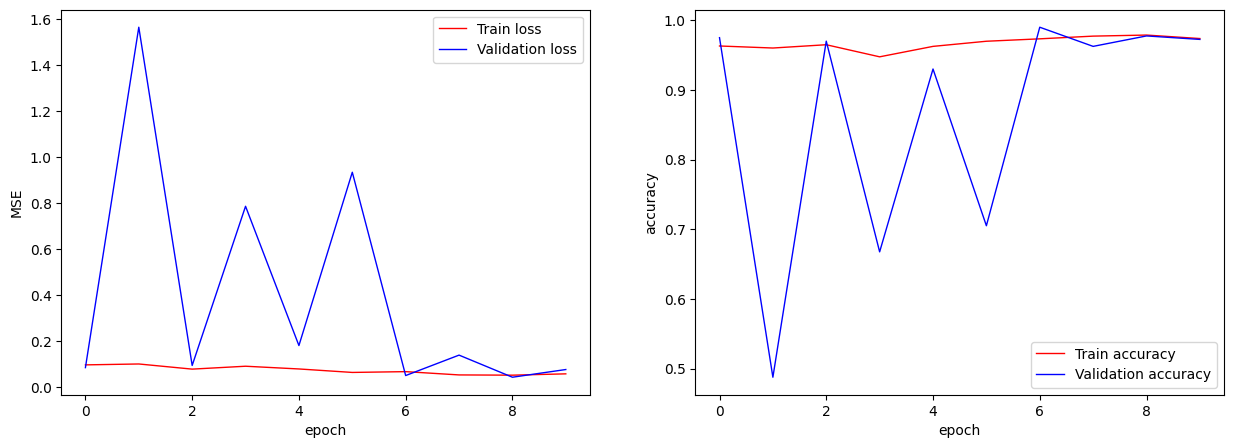

In [48]:
train_loop(10, 200, 0.002)

Epoch : 1, train accuracy : 0.9749999642372131, train loss : 0.061287105083465576
Epoch : 1, val_accuracy : 0.8186274766921997, val_loss : 0.5775023102760315
Epoch : 2, train accuracy : 0.9752500057220459, train loss : 0.06159748509526253
Epoch : 2, val_accuracy : 0.9754902124404907, val_loss : 0.07114227861166
Epoch : 3, train accuracy : 0.9727499485015869, train loss : 0.055590707808732986
Epoch : 3, val_accuracy : 0.9313725233078003, val_loss : 0.14359264075756073
Epoch : 4, train accuracy : 0.9660000205039978, train loss : 0.07047685980796814
Epoch : 4, val_accuracy : 0.9558823704719543, val_loss : 0.10829204320907593
Epoch : 5, train accuracy : 0.971500039100647, train loss : 0.061986446380615234
Epoch : 5, val_accuracy : 0.9803921580314636, val_loss : 0.05891171470284462
Epoch : 6, train accuracy : 0.9732500314712524, train loss : 0.05181766301393509
Epoch : 6, val_accuracy : 0.936274528503418, val_loss : 0.14067572355270386
Epoch : 7, train accuracy : 0.9727500677108765, train l

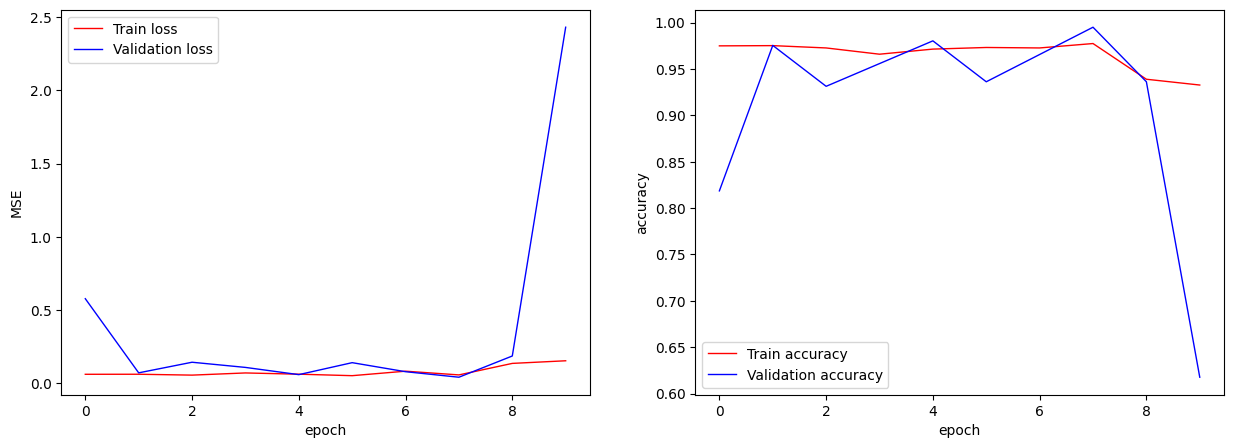

In [49]:
train_loop(10, 400, 0.002)

Epoch : 1, train accuracy : 0.96833336353302, train loss : 0.0871007889509201
Epoch : 1, val_accuracy : 0.9700000286102295, val_loss : 0.12201154232025146
Epoch : 2, train accuracy : 0.9722222685813904, train loss : 0.06535717099905014
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 1.0922274589538574
Epoch : 3, train accuracy : 0.9794445037841797, train loss : 0.062091998755931854
Epoch : 3, val_accuracy : 0.7274999618530273, val_loss : 0.36694082617759705
Epoch : 4, train accuracy : 0.9491665959358215, train loss : 0.12518611550331116
Epoch : 4, val_accuracy : 0.9850000143051147, val_loss : 0.04455448314547539
Epoch : 5, train accuracy : 0.9519444704055786, train loss : 0.1108364462852478
Epoch : 5, val_accuracy : 0.30000001192092896, val_loss : 4.1370320320129395
Epoch : 6, train accuracy : 0.9655556082725525, train loss : 0.10173394531011581
Epoch : 6, val_accuracy : 0.9700000286102295, val_loss : 0.08439838141202927
Epoch : 7, train accuracy : 0.9738889336585999, train lo

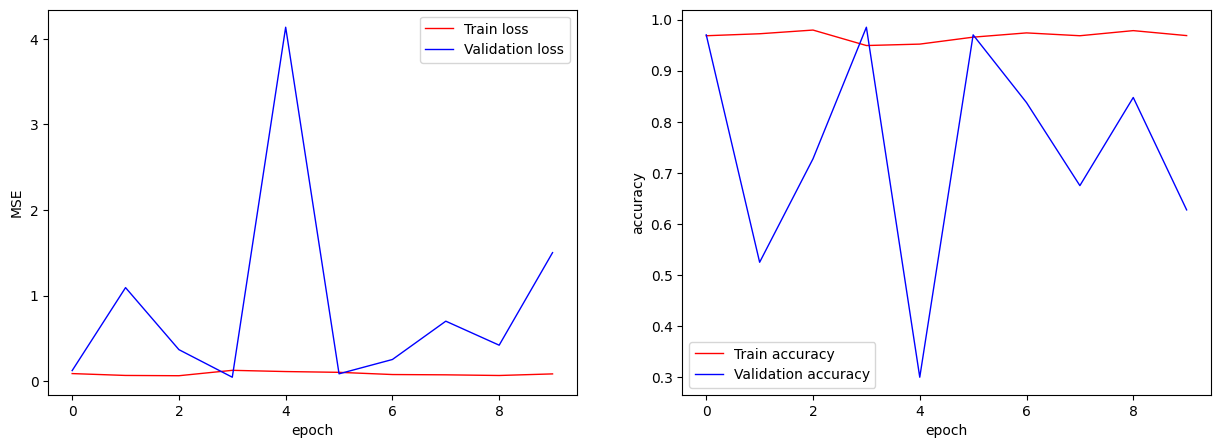

In [50]:
train_loop(10, 200, 0.003)

Epoch : 1, train accuracy : 0.9467499256134033, train loss : 0.10976575314998627
Epoch : 1, val_accuracy : 0.8774510025978088, val_loss : 0.31227028369903564
Epoch : 2, train accuracy : 0.969749927520752, train loss : 0.07542124390602112
Epoch : 2, val_accuracy : 0.9754902124404907, val_loss : 0.048897817730903625
Epoch : 3, train accuracy : 0.9800000190734863, train loss : 0.05576737970113754
Epoch : 3, val_accuracy : 0.9558823704719543, val_loss : 0.14812086522579193
Epoch : 4, train accuracy : 0.9679999947547913, train loss : 0.06801261752843857
Epoch : 4, val_accuracy : 0.906862735748291, val_loss : 0.24949316680431366
Epoch : 5, train accuracy : 0.9640000462532043, train loss : 0.06885702162981033
Epoch : 5, val_accuracy : 0.9264705777168274, val_loss : 0.15831322968006134
Epoch : 6, train accuracy : 0.9797500371932983, train loss : 0.05568482726812363
Epoch : 6, val_accuracy : 0.9607843160629272, val_loss : 0.08087107539176941
Epoch : 7, train accuracy : 0.9614999890327454, train

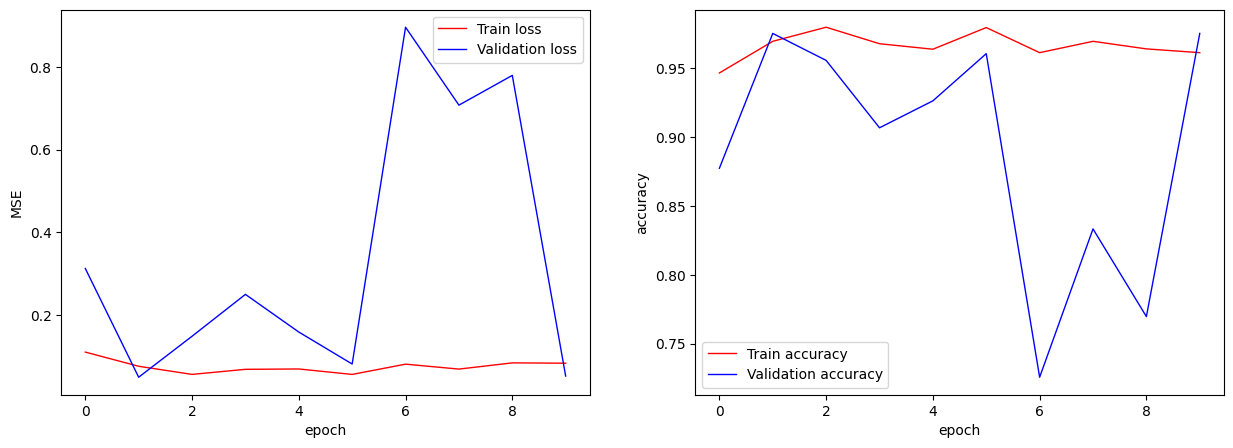

In [51]:
train_loop(10, 400, 0.003)

Проверка на тестовой выборке

Сохранение

In [52]:
#torch.save(model.state_dict(), "trained_model.pt")

Загрузка модели

In [53]:
model = CNN()
model.load_state_dict(torch.load("trained_model.pt"))
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Проверка на тестовом промежутке данных

In [54]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
test_loader = torch.utils.data.DataLoader(
        dataset=test_data, batch_size=1, shuffle=False
    )
model.eval()
test_loss = 0
test_accuracy = 0
for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    loss = criterion(output, label)

    acc = (output.argmax(dim=1) == label).float().mean()
    test_accuracy += acc
    test_loss += float(loss.detach()) 
print(test_loader.__len__())
test_accuracy / len(test_loader), test_loss/ len(test_loader)

204


(tensor(0.8873), 0.22122869307388382)

In [55]:
test_list.iloc[100][0]

C:\Users\zabir\AppData\Local\Temp\ipykernel_11076\1789832358.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_list.iloc[100][0]


'D:\\python\\dataset\\tiger\\0916.jpg'

In [56]:
label>=0.5

tensor([True])

Проверка рандомных картинок

C:\Users\zabir\AppData\Local\Temp\ipykernel_11076\1935619043.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = Image.open(test_list.iloc[index1][0])
C:\Users\zabir\AppData\Local\Temp\ipykernel_11076\1935619043.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = Image.open(test_list.iloc[index2][0])


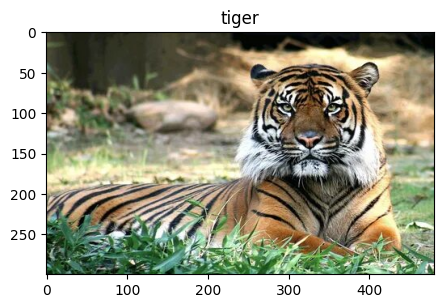

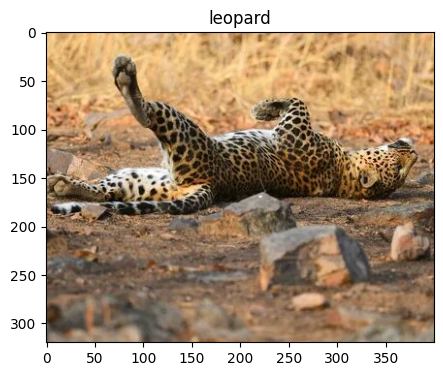

In [58]:

test_loader = torch.utils.data.DataLoader(
        dataset=test_data, batch_size=1, shuffle=False
    )
i = 0
index1 = random.randint(0, 200)
index2 = random.randint(0, 200)
for data, label in test_loader:
  if i == index1:
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("leopard" if (label >= 0.5) else "tiger")
    img = Image.open(test_list.iloc[index1][0])
    ax.imshow(img)
  if i == index2:
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("leopard" if (label >= 0.5) else "tiger")
    img = Image.open(test_list.iloc[index2][0])
    ax.imshow(img)
  i+=1